In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn import metrics
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
with open("cleaned_bikes2.pkl", 'rb') as picklefile: 
    united_df = pickle.load(picklefile)

***XGBoost***

- Insufficient time to correct the warning errors before the project deadline, still unsure why I was getting the errors in the notebook. I will continue to look into the errors that I got from the model. 
- I suspect that when I have corrected the error and can passed hyperparameters into the model it will outperform RandomForest

In [3]:
features = ['tripduration', 'gender','month','dayoftheweek','birth year','day','stop_time','start_time','start station latitude','end station latitude','start station longitude','end station longitude']

X = united_df[features].apply(pd.to_numeric, errors='coerce')
y = united_df['subscriber']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2, stratify=y_train)

In [4]:
gbm = xgb.XGBClassifier( 
        n_estimators=30000,
        max_depth=5,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=50,
                verbose=False)

metrics.accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

[13:52:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:52:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


0.8433247052319716

In [5]:
pickle.dump(gbm, open('xgboost2.pkl','wb'))

In [6]:
y_preds = gbm.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_preds)
precision = metrics.precision_score(y_test, y_preds)
recall = metrics.recall_score(y_test, y_preds)
f1 = metrics.f1_score(y_test, y_preds)
fbeta = metrics.fbeta_score(y_test, y_preds, beta=.25)

print("Accuracy:" , round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))
print("Fbeta Score:", round(fbeta, 3))

Accuracy: 0.843
Precision: 0.85
Recall: 0.542
F1 Score: 0.662
Fbeta Score: 0.823


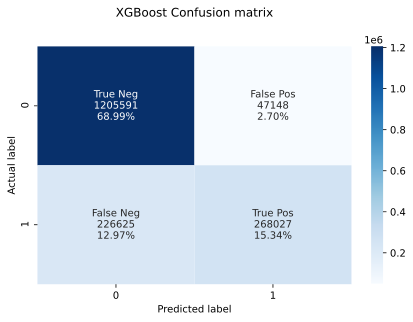

In [7]:
y_preds = gbm.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_preds)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');
plt.tight_layout()
plt.title('XGBoost Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');
plt.savefig("XGBoost - Confusion Matrix2.svg", bbox_inches='tight')

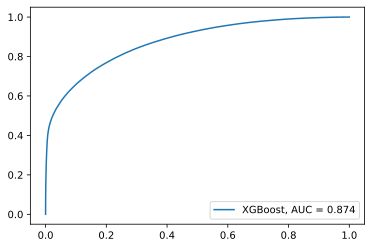

In [8]:
y_pred_proba = gbm.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=f"XGBoost, AUC = {round(auc, 3)}")
plt.legend(loc=4)
plt.savefig("XGBoost ROC-AUC2.svg", bbox_inches='tight');

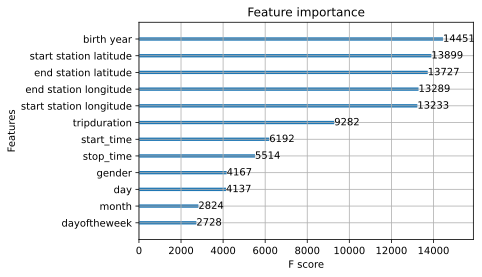

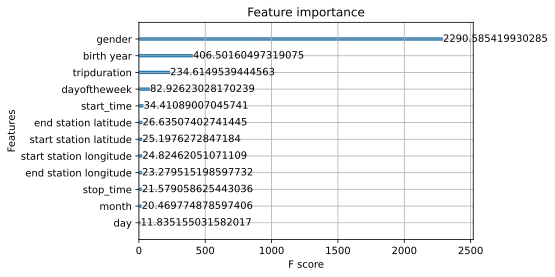

In [9]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain');